# La Réunion: download and plot

This minimal notebook downloads a GMRT GeoTIFF for La Réunion and plots it on a map.

- Bounds (lon/lat): [55.0, -21.5, 56.0, -20.5]
- Format: geotiff (medium resolution)
- Output folder: ./data

## Quick import and help

In [1]:
import pygmrt

[[[nan nan nan  0.]
  [nan nan nan  0.]
  [nan nan nan  0.]
  ...
  [nan nan nan  0.]
  [nan nan nan  0.]
  [nan nan nan  0.]]

 [[nan nan nan  0.]
  [nan nan nan  0.]
  [nan nan nan  0.]
  ...
  [nan nan nan  0.]
  [nan nan nan  0.]
  [nan nan nan  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  ...
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 ...

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  ...
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[nan nan nan  0.]
  [nan nan nan  0.]
  [nan nan nan  0.]
  ...
  [nan nan nan  0.]
  [nan nan nan  0.]
  [nan nan nan  0.]]

 [[nan nan nan  0.]
  [nan nan nan  0.]
  [nan nan nan  0.]
  ...
  [nan nan nan  0.]
  [nan nan nan  0.]
  [nan nan nan  0.]]]


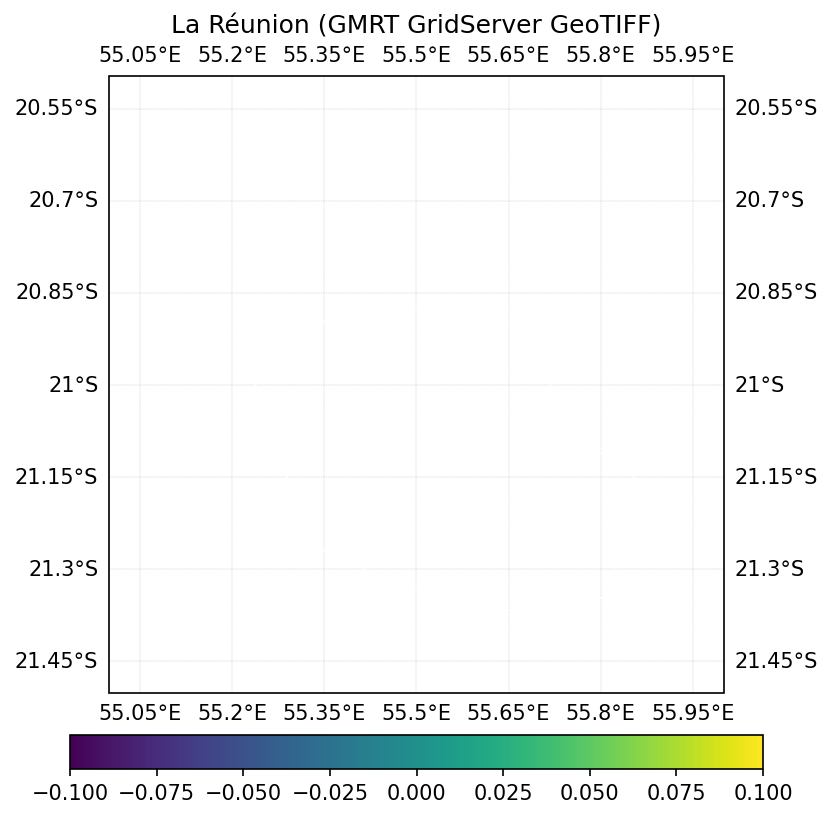

In [ ]:
import numpy as np

# Download a GeoTIFF of La Réunion and plot it using GMRT GridServer (no API key)
from pathlib import Path
from pygmrt.tiles import download_tiles
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import rasterio

from matplotlib.colors import LightSource

# La Réunion bbox [west, south, east, north]
bbox = [55.0, -21.5, 56.0, -20.5]
save_directory = "./data"

# Force re-download to avoid stale/corrupt cache if needed
result = download_tiles(
    bbox=bbox,
    save_directory=save_directory,
    resolution="low",
    overwrite=False,
)

# Find a created/reused GeoTIFF path
tif_path = None
for e in result.entries:
    p = Path(e.path)
    if (
        e.status in ("created", "reused")
        and p.exists()
        and p.suffix.lower() in (".tif", ".tiff")
    ):
        tif_path = p
        break
if tif_path is None:
    raise RuntimeError(
        "No GeoTIFF returned. Check API availability or parameters."
    )

# Plot
with rasterio.open(tif_path) as src:
    band1 = src.read(1)
    # replace nans
    vabsmax = np.nanmax(abs(band1))
    b = src.bounds
    extent = (b.left, b.right, b.bottom, b.top)

    fig, ax = plt.subplots(
        subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(9, 6), dpi=150
    )

    ls = LightSource(azdeg=0, altdeg=45)
    hillshade = ls.shade(band1, cmap=plt.cm.Greys)
    # print(hillshade)

    im = ax.imshow(
        hillshade,
        extent=extent,
        origin="upper",
        transform=ccrs.PlateCarree(),
        # cmap="Greys",
        # vmin=-vabsmax,
        # vmax=vabsmax,
    )
    ax.gridlines(
        draw_labels=True,
        linewidth=0.2,
        color="gray",
        alpha=0.5,
        linestyle="--",
    )
    ax.coastlines("10m", color="white", linewidth=0.6, zorder=10)
    ax.set_title("La Réunion (GMRT GridServer GeoTIFF)")
    plt.colorbar(im, ax=ax, orientation="horizontal", fraction=0.05, pad=0.06)
    plt.show()